In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        pass\n        #print(os.path.join(dirname, filename))"

# Setup

In [ ]:
pip install --upgrade keras tensorflow

In [ ]:
pip install scikeras

In [ ]:
pip install -U "tensorflow"

In [ ]:
pip install "tensorflow<=2.10.1"

In [ ]:
pip install "keras<=2.10.1"

In [1]:
# Standard libs
import os
import glob
import random
import ntpath
import datetime
import time as tm
from time import time
from operator import itemgetter

# Numerical & data
import numpy as np
import pandas as pd

# SciPy / skimage / cv
from scipy import ndimage, signal         
from skimage.util.shape import view_as_blocks
import cv2

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, cohen_kappa_score, hamming_loss, log_loss,
    zero_one_loss, matthews_corrcoef, precision_recall_fscore_support
)

# Yellowbrick (visualizers)
from yellowbrick.classifier import (
    ClassificationReport, ClassPredictionError, ConfusionMatrix, ROCAUC, PrecisionRecallCurve
)
from yellowbrick.style import find_text_color
from yellowbrick.style.palettes import color_sequence

# TensorFlow / Keras (use tensorflow.keras consistently)
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# SciKeras (replacement for removed wrappers)
from scikeras.wrappers import KerasClassifier


2025-10-28 19:40:27.430042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761680427.625771     514 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761680427.683465     514 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.utils import to_categorical

# SRM Filter

In [3]:
srm_weights = np.load('/kaggle/input/srm-kernels/other/srm_kernels/1/SRM_Kernels1.npy') 
biasSRM=np.ones(30)
print (srm_weights.shape)

(5, 5, 1, 30)


In [4]:
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3

In [5]:
n=256
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=np.array(X)
    return X

In [6]:
pathc = '/kaggle/input/bossbase-bows2/GBRASNET/BOSSbase-1.01'
paths = '/kaggle/input/bossbase-bows2/GBRASNET/BOSSbase-1.01/stego/S-UNIWARD/0.4bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (np.vstack((Xc_, Xs_)))
Xt_ = (np.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

In [7]:
print("Total image data and labels",X_.shape,Xt_.shape)
#Cover hasta las 10000 ##Train hasta las 4000 ##Valid hasta de las 4000 a las 5000 ##Test de las 5000 a las 10000
X_train = np.concatenate([X_[0:4000],X_[10000:14000]],axis=0)
X_valid = np.concatenate([X_[4000:5000],X_[14000:15000]],axis=0)
X_test  = np.concatenate([X_[5000:10000],X_[15000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
y_valid = np.concatenate([Xt_[4000:5000],Xt_[14000:15000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)
#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64) 
X_train = np.concatenate([X_dat0,X_dat1],axis=0) 
y_train = np.concatenate([y_dat0,y_dat1],axis=0) 
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (20000, 256, 256, 1) (20000, 2)
(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


In [9]:
def DAN_Model():
    tf.keras.backend.clear_session()
    
    # input 
    inputs = tf.keras.Input(shape=(256, 256, 1), name="input")
    
    # Residual Feature Extraction with SRM + TLU
    
    srm_layer = tf.keras.layers.Conv2D(30, (5,5), strides=(1,1), padding='same', 
                                     trainable=False, activation=Tanh3, use_bias=True)
    layers = srm_layer(inputs)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001)(layers)
    
    # DAN Network (Dual Attention Network) - ENCODER
    
    def residual_attention_block(x, filters, name_prefix=""):
        
        main = x
        
        # Channel Attention Mechanism
        gap = tf.keras.layers.GlobalAveragePooling2D()(main)
        gap = tf.keras.layers.Reshape((1, 1, filters))(gap)
        
        # Conv (1×1) for reduction + ReLU
        reduced = tf.keras.layers.Conv2D(filters//4, (1,1), activation='relu', 
                                       kernel_initializer='he_normal',
                                       name=f'{name_prefix}_channel_reduce')(gap)
        
        # Conv (1×1) for expansion + Sigmoid
        attention_weights = tf.keras.layers.Conv2D(filters, (1,1), activation='sigmoid', 
                                                 kernel_initializer='he_normal',
                                                 name=f'{name_prefix}_channel_expand')(reduced)
        
        # Channel Re-weighting
        x = tf.keras.layers.Multiply(name=f'{name_prefix}_channel_attention')([main, attention_weights])
        
        # Spatial processing
        x = tf.keras.layers.Conv2D(filters, (3,3), activation='relu', padding='same',
                                 kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        # Residual connection
        x = tf.keras.layers.Add()([main, x])
        
        return x
    
    
    layers = residual_attention_block(layers, 30, "block1")
    
    # Downsample to 128x128 using strided convolution
    layers = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), activation='relu', padding='same',
                                  kernel_initializer='he_normal')(layers)  # 128x128
    
    layers = residual_attention_block(layers, 32, "block2")
    
    # Downsample to 64x64
    layers = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), activation='relu', padding='same',
                                  kernel_initializer='he_normal')(layers)  # 64x64
    
    layers = residual_attention_block(layers, 64, "block3")
    
    # Downsample to 32x32
    layers = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), activation='relu', padding='same',
                                  kernel_initializer='he_normal')(layers)  # 32x32
    
    # Global features for classification
    global_features = tf.keras.layers.GlobalAveragePooling2D()(layers)
    
    # Dual Branch Outputs
    
    # Classifier Branch
    classifier_branch = tf.keras.layers.Dense(128, activation='relu', 
                                            kernel_initializer='he_normal')(global_features)
    classifier_branch = tf.keras.layers.Dropout(0.3)(classifier_branch)
    classifier_branch = tf.keras.layers.Dense(64, activation='relu',
                                            kernel_initializer='he_normal')(classifier_branch)
    classifier_output = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(classifier_branch)
    
    # Generator Branch
    
    gen_branch = tf.keras.layers.Dense(256, activation='relu')(global_features)
    gen_branch = tf.keras.layers.Dropout(0.3)(gen_branch)
    gen_branch = tf.keras.layers.Dense(512, activation='relu')(gen_branch)
    gen_branch = tf.keras.layers.Dense(1024, activation='relu')(gen_branch)
    gen_branch = tf.keras.layers.Dense(2048, activation='relu')(gen_branch)
    gen_branch = tf.keras.layers.Dense(256*256*1, activation='sigmoid')(gen_branch)  # 256x256
    generator_output = tf.keras.layers.Reshape((256, 256, 1), name='generator')(gen_branch)
    
    model = tf.keras.Model(inputs=inputs, outputs=[classifier_output, generator_output])
    
    # MANUALLY SET SRM WEIGHTS AFTER MODEL CREATION
    srm_layer.set_weights([srm_weights, biasSRM])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    print("Your DAN Steganalysis Model with Fixed Dimensions Generated")
    
    # Model compilation with dual losses
    model.compile(
        optimizer=optimizer,
        loss={
            'classifier': 'categorical_crossentropy',
            'generator': 'mean_squared_error'
        },
        loss_weights={'classifier': 0.7, 'generator': 0.3},
        metrics={
            'classifier': ['accuracy'],
            'generator': ['mae']
        }
    )
    
    return model

In [10]:
def train_model(model, X_train, y_train_class, X_valid, y_valid_class, 
                    X_test, y_test_class, batch_size, epochs, model_name=""):

    import datetime
    import os
    
    num_samples = len(X_train)
    num_cover = num_samples // 2
    
    print(f"Total training samples: {num_samples}")
    print(f"Cover images: {num_cover}")
    print(f"Stego images: {num_cover}")
    
    X_train_generator_targets = np.zeros_like(X_train)
    X_train_generator_targets[:num_cover] = X_train[:num_cover]  # Cover targets
    X_train_generator_targets[num_cover:] = X_train[:num_cover]  # Stego targets 
    
    train_outputs = {
        'classifier': y_train_class,          
        'generator': X_train_generator_targets 
    }
    
    num_valid_samples = len(X_valid)
    num_cover_valid = num_valid_samples // 2
    X_valid_generator_targets = np.zeros_like(X_valid)
    X_valid_generator_targets[:num_cover_valid] = X_valid[:num_cover_valid]
    X_valid_generator_targets[num_cover_valid:] = X_valid[:num_cover_valid]
    
    valid_outputs = {
        'classifier': y_valid_class,
        'generator': X_valid_generator_targets
    }
    
    log_dir = f"./logs/{model_name}_{datetime.datetime.now().isoformat()[:19].replace('T', '_').replace(':', '-')}"
    os.makedirs(log_dir, exist_ok=True)
    
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir + "/saved-model-{epoch:03d}-{val_classifier_accuracy:.4f}.keras"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_classifier_accuracy', 
                                                   save_best_only=False, mode='max')
    
    print("Starting the training...")
    print(f"Training data: {X_train.shape}")
    print(f"Training outputs - classifier: {y_train_class.shape}, generator: {X_train_generator_targets.shape}")
    print(f"Validation data: {X_valid.shape}")
    print(f"Validation outputs - classifier: {y_valid_class.shape}, generator: {X_valid_generator_targets.shape}")
    
    history = model.fit(
        X_train, 
        train_outputs,
        epochs=epochs, 
        callbacks=[tensorboard, checkpoint], 
        batch_size=batch_size,
        validation_data=(X_valid, valid_outputs),
        verbose=2
    )
    
    return history, log_dir

In [11]:
def train_model_simple(model, X_train, y_train, X_valid, y_valid, 
                           X_test, y_test, batch_size, epochs, model_name=""):
    """
    Simplified training function that works with your existing data structure
    """
    import datetime
    import os
    
    # Assuming your data is already in the correct GBRAS-Net format:
    # X_train: [cover_0, cover_1, ..., cover_3999, stego_0, stego_1, ..., stego_3999]
    # y_train: corresponding labels
    
    num_samples = len(X_train)
    num_cover = num_samples // 2
    
    # Create generator targets: ALL inputs should reconstruct to cover images
    X_train_gen_targets = np.concatenate([X_train[:num_cover], X_train[:num_cover]], axis=0)
    
    # For validation
    num_valid = len(X_valid)
    num_cover_valid = num_valid // 2
    X_valid_gen_targets = np.concatenate([X_valid[:num_cover_valid], X_valid[:num_cover_valid]], axis=0)
    
    train_outputs = {'classifier': y_train, 'generator': X_train_gen_targets}
    valid_outputs = {'classifier': y_valid, 'generator': X_valid_gen_targets}
    
    # Callbacks
    log_dir = f"./logs/{model_name}_{datetime.datetime.now().isoformat()[:19].replace('T', '_').replace(':', '-')}"
    os.makedirs(log_dir, exist_ok=True)
    
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir + "/saved-model-{epoch:03d}-{val_classifier_accuracy:.4f}.keras"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_classifier_accuracy', 
                                                   save_best_only=False, mode='max')
    
    print("Training with simplified approach...")
    print(f"Shapes - X: {X_train.shape}, y_class: {y_train.shape}, y_gen: {X_train_gen_targets.shape}")
    
    history = model.fit(
        X_train, 
        train_outputs,
        epochs=epochs, 
        callbacks=[tensorboard, checkpoint], 
        batch_size=batch_size,
        validation_data=(X_valid, valid_outputs),
        verbose=2
    )
    
    return history, log_dir

In [12]:
model = DAN_Model()
model.summary()

I0000 00:00:1761680141.161849     388 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761680141.162505     388 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Your DAN Steganalysis Model with Fixed Dimensions Generated


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        780 │ input[0][0]       │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        120 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 30)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 30)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_channel_red… │ (None, 1, 1, 7)   │        217 │ reshape[0][0]     │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_channel_exp… │ (None, 1, 1, 30)  │        240 │ block1_channel_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_channel_att… │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Multiply)          │ 30)               │            │ block1_channel_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      8,130 │ block1_channel_a… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        120 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 30)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      8,672 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_channel_red… │ (None, 1, 1, 8)   │        264 │ reshape_1[0][0]   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_channel_exp… │ (None, 1, 1, 32)  │        288 │ block2_channel_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_channel_att… │ (None, 128, 128,  │          0 │ conv2d_2[0][0],   │
│ (Multiply)          │ 32)               │            │ block2_channel_e… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 137,257,153 (523.59 MB)

 Trainable params: 137,256,061 (523.59 MB)

 Non-trainable params: 1,092 (4.27 KB)

# DAN Model

In [ ]:
def DAN_Model():
    tf.keras.backend.clear_session()
    
    # Input Stage
    inputs = tf.keras.Input(shape=(256, 256, 1), name="input")
    
    # SRM Preprocessing (fixed, non-trainable)
    srm_layer = tf.keras.layers.Conv2D(30, (5,5), strides=(1,1), padding='same', 
                                     trainable=False, activation=Tanh3, use_bias=True)
    x = srm_layer(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Efficient Encoder with smaller dimensions
    x = tf.keras.layers.Conv2D(16, (3,3), strides=(2,2), activation='relu', padding='same')(x)  # 128x128
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), activation='relu', padding='same')(x)  # 64x64
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), activation='relu', padding='same')(x)  # 32x32
    x = tf.keras.layers.BatchNormalization()(x)
    
    global_features = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Dual Branch Outputs
    
    # Classifier Branch
    classifier_branch = tf.keras.layers.Dense(64, activation='relu')(global_features)
    classifier_branch = tf.keras.layers.Dropout(0.3)(classifier_branch)
    classifier_branch = tf.keras.layers.Dense(32, activation='relu')(classifier_branch)
    classifier_output = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(classifier_branch)
    
    # Generator Branch
    
    # Small generator - reconstruct to 64x64 instead of 256x256
    gen_branch = tf.keras.layers.Dense(128, activation='relu')(global_features)
    gen_branch = tf.keras.layers.Dense(256, activation='relu')(gen_branch)
    gen_branch = tf.keras.layers.Dense(64*64*1, activation='sigmoid')(gen_branch)  # 64x64
    generator_output = tf.keras.layers.Reshape((64, 64, 1), name='generator')(gen_branch)
    
    model = tf.keras.Model(inputs=inputs, outputs=[classifier_output, generator_output])
    
    # set SRM weights
    srm_layer.set_weights([srm_weights, biasSRM])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss={
            'classifier': 'categorical_crossentropy',
            'generator': 'mean_squared_error'
        },
        loss_weights={'classifier': 0.8, 'generator': 0.2},  # Focus more on classification
        metrics={
            'classifier': ['accuracy'],
            'generator': ['mae']
        }
    )
    
    print("Memory-efficient DAN Model Generated")
    return model

In [ ]:
def DAN_Model_Single_Output():
    tf.keras.backend.clear_session()
    
    inputs = tf.keras.Input(shape=(256, 256, 1), name="input")
    
    # SRM Preprocessing
    srm_layer = tf.keras.layers.Conv2D(30, (5,5), strides=(1,1), padding='same', 
                                     trainable=False, activation=Tanh3, use_bias=True)
    x = srm_layer(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Efficient encoder
    x = tf.keras.layers.Conv2D(16, (3,3), strides=(2,2), activation='relu', padding='same')(x)  # 128x128
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), activation='relu', padding='same')(x)  # 64x64
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), activation='relu', padding='same')(x)  # 32x32
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Single classifier output
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Set SRM weights
    srm_layer.set_weights([srm_weights, biasSRM])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Single-output DAN Model Generated (Most Memory Efficient)")
    return model


In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, 
                          batch_size=16, epochs=100, model_name=""):  #smaller batch
    import datetime
    import os
    
    log_dir = f"./logs/{model_name}_{datetime.datetime.now().isoformat()[:19].replace('T', '_').replace(':', '-')}"
    os.makedirs(log_dir, exist_ok=True)
    
    # for single-output model
    if len(model.output_names) == 1:
        print("Training single-output model...")
        
        tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
        filepath = log_dir + "/saved-model-{epoch:03d}-{val_accuracy:.4f}.keras"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', 
                                                       save_best_only=False, mode='max')
        
        history = model.fit(
            X_train, y_train,
            epochs=epochs, 
            callbacks=[tensorboard, checkpoint], 
            batch_size=batch_size,
            validation_data=(X_valid, y_valid),
            verbose=2
        )
    
    #fFor dual-output model
    else:
        print("Training dual-output model...")
        
        num_samples = len(X_train)
        num_cover = num_samples // 2
        
        X_train_gen_targets = np.zeros((num_samples, 64, 64, 1))
        X_valid_gen_targets = np.zeros((len(X_valid), 64, 64, 1))
        
        for i in range(num_samples):
            if i < num_cover:
                X_train_gen_targets[i] = tf.keras.layers.AveragePooling2D((4,4))(tf.expand_dims(X_train[i], 0))
            else:
                X_train_gen_targets[i] = tf.keras.layers.AveragePooling2D((4,4))(tf.expand_dims(X_train[i-num_cover], 0))
        
        for i in range(len(X_valid)):
            if i < len(X_valid)//2:
                X_valid_gen_targets[i] = tf.keras.layers.AveragePooling2D((4,4))(tf.expand_dims(X_valid[i], 0))
            else:
                X_valid_gen_targets[i] = tf.keras.layers.AveragePooling2D((4,4))(tf.expand_dims(X_valid[i-len(X_valid)//2], 0))
        
        train_outputs = {'classifier': y_train, 'generator': X_train_gen_targets}
        valid_outputs = {'classifier': y_valid, 'generator': X_valid_gen_targets}
        
        tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
        filepath = log_dir + "/saved-model-{epoch:03d}-{val_classifier_accuracy:.4f}.keras"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_classifier_accuracy', 
                                                       save_best_only=False, mode='max')
        
        history = model.fit(
            X_train, train_outputs,
            epochs=epochs, 
            callbacks=[tensorboard, checkpoint], 
            batch_size=batch_size,
            validation_data=(X_valid, valid_outputs),
            verbose=2
        )
    
    return history, log_dir

# Training (Main Code)

In [8]:
print("Creating memory-efficient single-output model...")
model = DAN_Model_Single_Output()
model.summary()

trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
total_params = trainable_params + non_trainable_params

print(f"\nMemory usage:")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Total parameters: {total_params:,}")

print("\nStarting memory-efficient training...")
try:
    history, log_dir = train(
        model,
        X_train, y_train,
        X_valid, y_valid,
        batch_size=16,  # smaller batch size
        epochs=50,      # Fewer epochs to test
        model_name="DAN_Model"
    )
    
    print(f"Training completed! Logs saved to: {log_dir}")
    
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    
except Exception as e:
    print(f"Memory error: {e}")
    print("Trying even more aggressive memory reduction...")
    
    # If still memory issues, try these:
    print("1. Reduce image size to 128x128")
    print("2. Use even smaller batch size (8)")
    print("3. Use gradient accumulation")

Creating memory-efficient single-output model...


I0000 00:00:1761680599.290063     514 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761680599.290693     514 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Single-output DAN Model Generated (Most Memory Efficient)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 30)   │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 30)   │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         4,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,126 (137.21 KB)

 Trainable params: 34,062 (133.05 KB)

 Non-trainable params: 1,064 (4.16 KB)


Memory usage:
Trainable parameters: 34,062
Non-trainable parameters: 1,064
Total parameters: 35,126

Starting memory-efficient training...
Training single-output model...
Epoch 1/50


I0000 00:00:1761680606.887707     551 service.cc:148] XLA service 0x7b1c7c016c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761680606.888462     551 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761680606.888481     551 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761680607.377154     551 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761680611.608244     551 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 - 23s - 46ms/step - accuracy: 0.5077 - loss: 0.6994 - val_accuracy: 0.5070 - val_loss: 0.6976
Epoch 2/50
500/500 - 11s - 22ms/step - accuracy: 0.5025 - loss: 0.6951 - val_accuracy: 0.5195 - val_loss: 0.6892
Epoch 3/50
500/500 - 11s - 22ms/step - accuracy: 0.5264 - loss: 0.6920 - val_accuracy: 0.5810 - val_loss: 0.6771
Epoch 4/50
500/500 - 11s - 22ms/step - accuracy: 0.5334 - loss: 0.6886 - val_accuracy: 0.6220 - val_loss: 0.6680
Epoch 5/50
500/500 - 11s - 22ms/step - accuracy: 0.5422 - loss: 0.6832 - val_accuracy: 0.6120 - val_loss: 0.6467
Epoch 6/50
500/500 - 11s - 22ms/step - accuracy: 0.5458 - loss: 0.6792 - val_accuracy: 0.6265 - val_loss: 0.6511
Epoch 7/50
500/500 - 11s - 23ms/step - accuracy: 0.5612 - loss: 0.6750 - val_accuracy: 0.6455 - val_loss: 0.6043
Epoch 8/50
500/500 - 12s - 23ms/step - accuracy: 0.5723 - loss: 0.6661 - val_accuracy: 0.5360 - val_loss: 0.7044
Epoch 9/50
500/500 - 11s - 23ms/step - accuracy: 0.5804 - loss: 0.6599 - val_accuracy: 0.6405 - val_loss: 0

# Saving Model and other files

In [10]:
def save_model_to_kaggle(model, model_name="your_dan_model"):

    import os
    import json
    from datetime import datetime
    

    model_dir = f"/kaggle/working/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    

    model_path = f"{model_dir}/{model_name}.keras"
    model.save(model_path)
    print(f"Model saved to: {model_path}")
    

    model_architecture = model.to_json()
    architecture_path = f"{model_dir}/{model_name}_architecture.json"
    with open(architecture_path, 'w') as f:
        f.write(model_architecture)
    print(f"Model architecture saved to: {architecture_path}")
    

    weights_path = f"{model_dir}/{model_name}.weights.h5"  
    model.save_weights(weights_path)
    print(f"Model weights saved to: {weights_path}")
    

    if 'history' in globals():
        history_path = f"{model_dir}/{model_name}_history.json"
        with open(history_path, 'w') as f:
            history_dict = {}
            for key, values in history.history.items():
                history_dict[key] = [float(value) for value in values]
            json.dump(history_dict, f)
        print(f"Training history saved to: {history_path}")
    
    summary_path = f"{model_dir}/{model_name}_summary.txt"
    with open(summary_path, 'w') as f:
        string_list = []
        model.summary(print_fn=lambda x: string_list.append(x))
        f.write("\n".join(string_list))
    print(f"Model summary saved to: {summary_path}")
    
    srm_path = f"{model_dir}/srm_filters.npy"
    np.save(srm_path, srm_weights)
    print(f"SRM filters saved to: {srm_path}")
    
    info = {
        'model_name': model_name,
        'input_shape': str(model.input_shape),
        'output_shapes': [str(output.shape) for output in model.outputs],
        'total_params': model.count_params(),
        'trainable_params': np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]),
        'non_trainable_params': np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]),
        'save_time': datetime.now().isoformat(),
        'custom_objects': ['Tanh3'],
        'model_type': 'Steganalysis_DAN_Model'
    }
    
    info_path = f"{model_dir}/{model_name}_info.json"
    with open(info_path, 'w') as f:
        json.dump(info, f, indent=2)
    print(f"Model info saved to: {info_path}")
    
    return model_dir

def list_saved_files(model_dir):
    """List all files in the model directory"""
    print(f"Contents of {model_dir}:")
    if os.path.exists(model_dir):
        for file in sorted(os.listdir(model_dir)):
            file_path = os.path.join(model_dir, file)
            file_size = os.path.getsize(file_path)
            print(f"  {file} ({file_size:,} bytes)")
    else:
        print(f"  Directory not found: {model_dir}")

def save_model_simple(model, model_name="your_dan_model"):
    """
    Save only the essential model files
    """
    import os
    
    model_dir = f"/kaggle/working/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    model_path = f"{model_dir}/{model_name}.keras"
    model.save(model_path)
    print(f"Model saved to: {model_path}")
    
    weights_path = f"{model_dir}/{model_name}.weights.h5"
    model.save_weights(weights_path)
    print(f"Model weights saved to: {weights_path}")
    
    srm_path = f"{model_dir}/srm_filters.npy"
    np.save(srm_path, srm_weights)
    print(f"SRM filters saved to: {srm_path}")
    
    return model_dir

def create_loading_script(model_name="your_dan_model"):
    """
    Create a Python script to load the model
    """
    script_content = f'''
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K

# Custom activation function for TLU
T3 = 3
def Tanh3(x):
    """Threshold Linear Unit (TLU) activation"""
    tanh3 = K.tanh(x) * T3
    return tanh3

def load_{model_name}(model_path="/kaggle/working/{model_name}/{model_name}.keras"):
    """
    Load your trained steganalysis model
    
    Args:
        model_path: Path to the saved .keras model file
        
    Returns:
        Loaded TensorFlow model
    """
    try:
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={{'Tanh3': Tanh3}},
            compile=True
        )
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {{e}}")
        return None

def predict_single_image(model, image):
    """
    Predict whether an image is cover or stego
    
    Args:
        model: Loaded model
        image: Grayscale image array (256, 256, 1)
        
    Returns:
        prediction: [cover_prob, stego_prob]
    """
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)
    return prediction[0]  # Return first prediction

if __name__ == "__main__":
    # Example usage
    model = load_{model_name}()
    if model:
        model.summary()
        print("Model ready for steganalysis!")
'''

    script_path = f"/kaggle/working/load_{model_name}.py"
    with open(script_path, 'w') as f:
        f.write(script_content)
    
    print(f"Loading script saved to: {script_path}")
    return script_path

def verify_model_save_load(model, model_name="your_dan_model"):
    """
    Test the complete save/load cycle
    """
    print("Testing model save/load cycle...")
    
    model_dir = save_model_simple(model, model_name)
    
    script_path = create_loading_script(model_name)
    
    try:
        T3 = 3
        def Tanh3(x):
            tanh3 = K.tanh(x) * T3
            return tanh3
        
        # Load model
        model_path = f"{model_dir}/{model_name}.keras"
        loaded_model = tf.keras.models.load_model(
            model_path,
            custom_objects={'Tanh3': Tanh3},
            compile=True
        )
        
        print("Model loaded successfully!")
        
        test_input = np.random.randn(1, 256, 256, 1).astype(np.float32)
        original_output = model.predict(test_input, verbose=0)
        loaded_output = loaded_model.predict(test_input, verbose=0)
        
        if len(original_output) == len(loaded_output):
            print("Predictions match!")
        else:
            print("Output structure changed after loading")
            
        return loaded_model
        
    except Exception as e:
        print(f"Error in save/load cycle: {e}")
        return None

print("=" * 60)
print("SAVING MODEL TO KAGGLE WORKING DIRECTORY")
print("=" * 60)

print("1. Saving essential model files...")
model_dir = save_model_simple(model, "your_dan_steganalysis_model")
list_saved_files(model_dir)

print("2. Creating loading script...")
script_path = create_loading_script("your_dan_steganalysis_model")

print("3. Verifying save/load cycle...")
loaded_model = verify_model_save_load(model, "your_dan_steganalysis_model")

print("=" * 60)
print("FINAL KAGGLE WORKING DIRECTORY STRUCTURE")
print("=" * 60)

working_dir = "/kaggle/working/"
model_files = []

for item in os.listdir(working_dir):
    if "your_dan" in item or "steganalysis" in item:
        item_path = os.path.join(working_dir, item)
        if os.path.isdir(item_path):
            model_files.append(f"DIR: {item}/")
            # List contents of model directory
            for file in os.listdir(item_path):
                file_path = os.path.join(item_path, file)
                size = os.path.getsize(file_path)
                model_files.append(f"   FILE: {file} ({size:,} bytes)")
        else:
            size = os.path.getsize(item_path)
            model_files.append(f"FILE: {item} ({size:,} bytes)")

for file_info in sorted(model_files):
    print(file_info)

print("=" * 60)
print("SAVE COMPLETE!")
print("=" * 60)
print("Your model has been saved to Kaggle working directory.")
print("You can download these files from the Kaggle output section.")
print("Essential files:")
print("  - your_dan_steganalysis_model.keras - Complete model")
print("  - your_dan_steganalysis_model.weights.h5 - Model weights") 
print("  - srm_filters.npy - SRM filter weights")
print("  - load_your_dan_steganalysis_model.py - Loading script")

SAVING MODEL TO KAGGLE WORKING DIRECTORY
1. Saving essential model files...
Model saved to: /kaggle/working/your_dan_steganalysis_model/your_dan_steganalysis_model.keras
Model weights saved to: /kaggle/working/your_dan_steganalysis_model/your_dan_steganalysis_model.weights.h5
SRM filters saved to: /kaggle/working/your_dan_steganalysis_model/srm_filters.npy
Contents of /kaggle/working/your_dan_steganalysis_model:
  srm_filters.npy (3,128 bytes)
  your_dan_steganalysis_model.keras (490,936 bytes)
  your_dan_steganalysis_model.weights.h5 (476,584 bytes)
  your_dan_steganalysis_model_architecture.json (14,231 bytes)
2. Creating loading script...
Loading script saved to: /kaggle/working/load_your_dan_steganalysis_model.py
3. Verifying save/load cycle...
Testing model save/load cycle...
Model saved to: /kaggle/working/your_dan_steganalysis_model/your_dan_steganalysis_model.keras
Model weights saved to: /kaggle/working/your_dan_steganalysis_model/your_dan_steganalysis_model.weights.h5
SRM fil

# Training Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_training_history(history, model_name="Your_DAN_Model"):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    if 'accuracy' in history.history:
        ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    if 'classifier_accuracy' in history.history:
        ax1.plot(history.history['classifier_accuracy'], label='Training Classifier Accuracy', linewidth=2)
    if 'val_classifier_accuracy' in history.history:
        ax1.plot(history.history['val_classifier_accuracy'], label='Validation Classifier Accuracy', linewidth=2)
    
    ax1.set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    if 'loss' in history.history:
        ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    if 'classifier_loss' in history.history:
        ax2.plot(history.history['classifier_loss'], label='Training Classifier Loss', linewidth=2)
    if 'val_classifier_loss' in history.history:
        ax2.plot(history.history['val_classifier_loss'], label='Validation Classifier Loss', linewidth=2)
    
    ax2.set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_dual_output_training(history, model_name="Your_DAN_Model"):

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # Classifier Accuracy
    if 'classifier_accuracy' in history.history:
        ax1.plot(history.history['classifier_accuracy'], label='Training', linewidth=2)
    if 'val_classifier_accuracy' in history.history:
        ax1.plot(history.history['val_classifier_accuracy'], label='Validation', linewidth=2)
    
    ax1.set_title('Classifier Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Classifier Loss
    if 'classifier_loss' in history.history:
        ax2.plot(history.history['classifier_loss'], label='Training', linewidth=2)
    if 'val_classifier_loss' in history.history:
        ax2.plot(history.history['val_classifier_loss'], label='Validation', linewidth=2)
    
    ax2.set_title('Classifier Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Generator MAE (Mean Absolute Error)
    if 'generator_mae' in history.history:
        ax3.plot(history.history['generator_mae'], label='Training', linewidth=2)
    if 'val_generator_mae' in history.history:
        ax3.plot(history.history['val_generator_mae'], label='Validation', linewidth=2)
    
    ax3.set_title('Generator MAE', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('MAE')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Generator Loss
    if 'generator_loss' in history.history:
        ax4.plot(history.history['generator_loss'], label='Training', linewidth=2)
    if 'val_generator_loss' in history.history:
        ax4.plot(history.history['val_generator_loss'], label='Validation', linewidth=2)
    
    ax4.set_title('Generator Loss', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'{model_name} - Dual Output Training History', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_comparison_curves(history, acc_test=None, loss_test=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy comparison
    if 'accuracy' in history.history:
        ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    if acc_test is not None:
        ax1.plot(acc_test, label='Test Accuracy', linewidth=2, linestyle='--')
    
    ax1.set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss comparison
    if 'loss' in history.history:
        ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    if loss_test is not None:
        ax2.plot(loss_test, label='Test Loss', linewidth=2, linestyle='--')
    
    ax2.set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_training_summary(history):

    print("TRAINING SUMMARY")
    print("=" * 50)
    
    metrics = {}
    
    for key in history.history.keys():
        values = history.history[key]
        best_epoch = np.argmax(values) if 'accuracy' in key or 'mae' in key else np.argmin(values)
        best_value = values[best_epoch]
        metrics[key] = {'best_epoch': best_epoch + 1, 'best_value': best_value}
    
    classifier_metrics = [k for k in metrics.keys() if 'classifier' in k or 'accuracy' in k or 'loss' in k]
    
    print("CLASSIFIER METRICS:")
    for metric in classifier_metrics:
        if 'accuracy' in metric:
            print(f"  {metric}: {metrics[metric]['best_value']:.4f} (epoch {metrics[metric]['best_epoch']})")
    
    for metric in classifier_metrics:
        if 'loss' in metric and 'accuracy' not in metric:
            print(f"  {metric}: {metrics[metric]['best_value']:.4f} (epoch {metrics[metric]['best_epoch']})")
    
    generator_metrics = [k for k in metrics.keys() if 'generator' in k]
    if generator_metrics:
        print("\nGENERATOR METRICS:")
        for metric in generator_metrics:
            print(f"  {metric}: {metrics[metric]['best_value']:.4f} (epoch {metrics[metric]['best_epoch']})")
    
    print(f"\nFINAL EPOCH (Epoch {len(history.history['loss'])}):")
    for key in history.history.keys():
        if any(x in key for x in ['accuracy', 'loss', 'mae']):
            final_value = history.history[key][-1]
            print(f"  {key}: {final_value:.4f}")

def plot_learning_curves_detailed(history):

    def smooth_curve(points, factor=0.9):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    # Plot 1: Accuracy curves
    if 'accuracy' in history.history:
        axes[0].plot(history.history['accuracy'], alpha=0.3, label='Training (raw)')
        axes[0].plot(smooth_curve(history.history['accuracy']), label='Training (smoothed)', linewidth=2)
    if 'val_accuracy' in history.history:
        axes[0].plot(history.history['val_accuracy'], alpha=0.3, label='Validation (raw)')
        axes[0].plot(smooth_curve(history.history['val_accuracy']), label='Validation (smoothed)', linewidth=2)
    
    axes[0].set_title('Accuracy Learning Curves', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Loss curves
    if 'loss' in history.history:
        axes[1].plot(history.history['loss'], alpha=0.3, label='Training (raw)')
        axes[1].plot(smooth_curve(history.history['loss']), label='Training (smoothed)', linewidth=2)
    if 'val_loss' in history.history:
        axes[1].plot(history.history['val_loss'], alpha=0.3, label='Validation (raw)')
        axes[1].plot(smooth_curve(history.history['val_loss']), label='Validation (smoothed)', linewidth=2)
    
    axes[1].set_title('Loss Learning Curves', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Learning rate 
    if 'lr' in history.history:
        axes[2].plot(history.history['lr'], linewidth=2)
        axes[2].set_title('Learning Rate', fontweight='bold')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Learning Rate')
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].set_visible(False)
    
    # Plot 4: Additional metrics
    additional_metrics = [k for k in history.history.keys() if k not in ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'lr']]
    if additional_metrics:
        for metric in additional_metrics[:1]:  # Plot first additional metric
            axes[3].plot(history.history[metric], label=metric, linewidth=2)
        axes[3].set_title('Additional Metrics', fontweight='bold')
        axes[3].set_xlabel('Epoch')
        axes[3].set_ylabel('Metric Value')
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)
    else:
        axes[3].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig  

def save_training_plots(history, model_name="Your_DAN_Model", save_dir="/kaggle/working/training_plots"):
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Plot 1: Basic training history
    print("Saving basic training history plot...")
    fig1 = plot_training_history(history, model_name)
    fig1.savefig(f"{save_dir}/{model_name}_training_history.png", dpi=300, bbox_inches='tight')
    plt.close(fig1)
    
    # Plot 2: Dual output training (if applicable)
    if any('classifier' in key for key in history.history.keys()):
        print("Saving dual output training plot...")
        fig2 = plot_dual_output_training(history, model_name)
        fig2.savefig(f"{save_dir}/{model_name}_dual_output_training.png", dpi=300, bbox_inches='tight')
        plt.close(fig2)
    
    # Plot 3: Detailed learning curves
    print("Saving detailed learning curves...")
    fig3 = plot_learning_curves_detailed(history)
    fig3.savefig(f"{save_dir}/{model_name}_detailed_curves.png", dpi=300, bbox_inches='tight')
    plt.close(fig3)
    
    print(f"Training plots saved to: {save_dir}")


def quick_visualize_training(history, model_name="Your_DAN_Model"):

    plots_dir = "/kaggle/working/training_plots"
    os.makedirs(plots_dir, exist_ok=True)
    
    print("Available metrics:", list(history.history.keys()))
    
    # Basic accuracy and loss plot
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    if 'classifier_accuracy' in history.history:
        plt.plot(history.history['classifier_accuracy'], label='Train Classifier Acc')
    if 'val_classifier_accuracy' in history.history:
        plt.plot(history.history['val_classifier_accuracy'], label='Val Classifier Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    if 'classifier_loss' in history.history:
        plt.plot(history.history['classifier_loss'], label='Train Classifier Loss')
    if 'val_classifier_loss' in history.history:
        plt.plot(history.history['val_classifier_loss'], label='Val Classifier Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{plots_dir}/{model_name}_quick_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\nTRAINING SUMMARY:")
    print("Best Training Accuracy:", max(history.history.get('accuracy', history.history.get('classifier_accuracy', [0]))))
    print("Best Validation Accuracy:", max(history.history.get('val_accuracy', history.history.get('val_classifier_accuracy', [0]))))
    print("Final Training Loss:", history.history['loss'][-1] if 'loss' in history.history else history.history.get('classifier_loss', [0])[-1])
    print("Final Validation Loss:", history.history.get('val_loss', [0])[-1] if 'val_loss' in history.history else history.history.get('val_classifier_loss', [0])[-1])

VISUALIZING TRAINING RESULTS
Generating quick visualization...
Available metrics: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


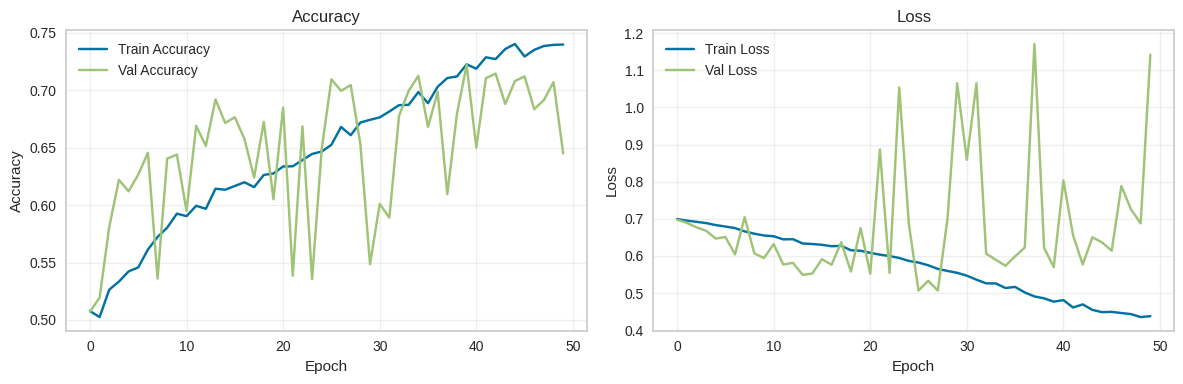


TRAINING SUMMARY:
Best Training Accuracy: 0.7402499914169312
Best Validation Accuracy: 0.722000002861023
Final Training Loss: 0.437733918428421
Final Validation Loss: 1.1424353122711182

GENERATING DETAILED PLOTS
TRAINING SUMMARY
CLASSIFIER METRICS:
  accuracy: 0.7402 (epoch 45)
  val_accuracy: 0.7220 (epoch 40)
  loss: 0.4353 (epoch 49)
  val_loss: 0.5068 (epoch 26)

FINAL EPOCH (Epoch 50):
  accuracy: 0.7398
  loss: 0.4377
  val_accuracy: 0.6450
  val_loss: 1.1424
Single-output model detected - plotting basic training curves...


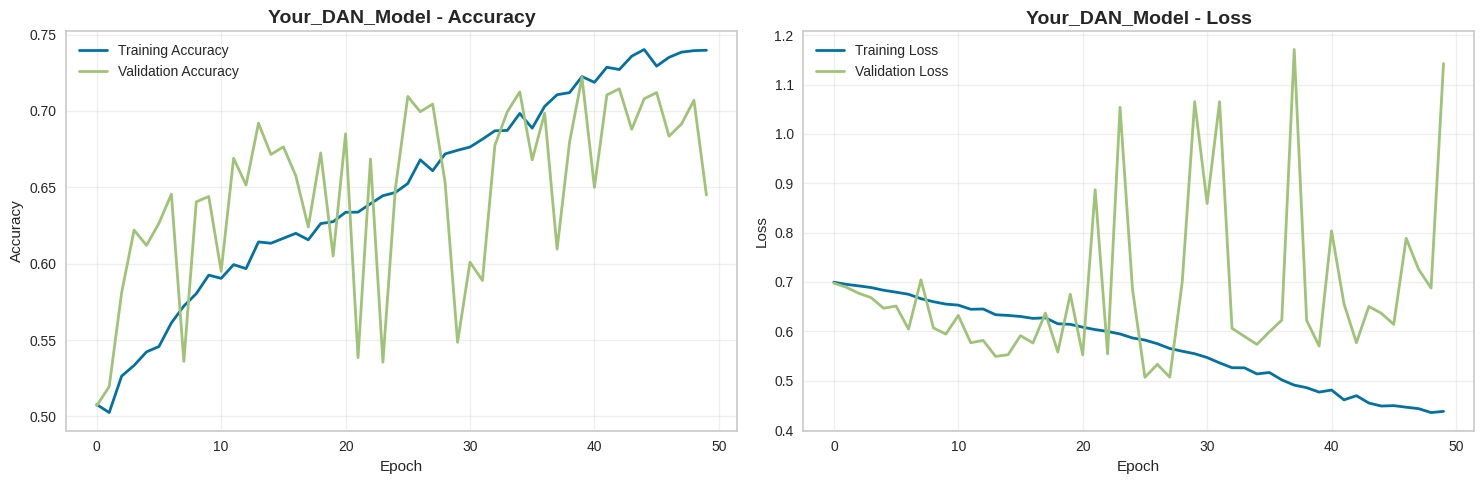


Plotting detailed learning curves...


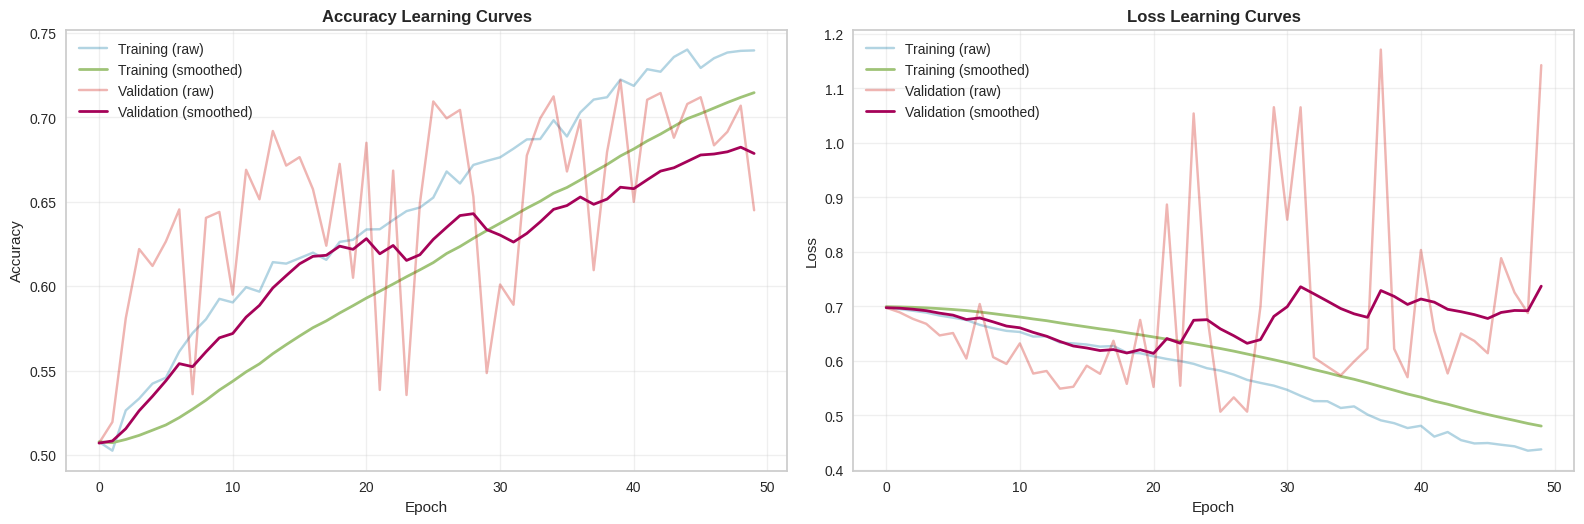


Saving plots to files...
Saving basic training history plot...


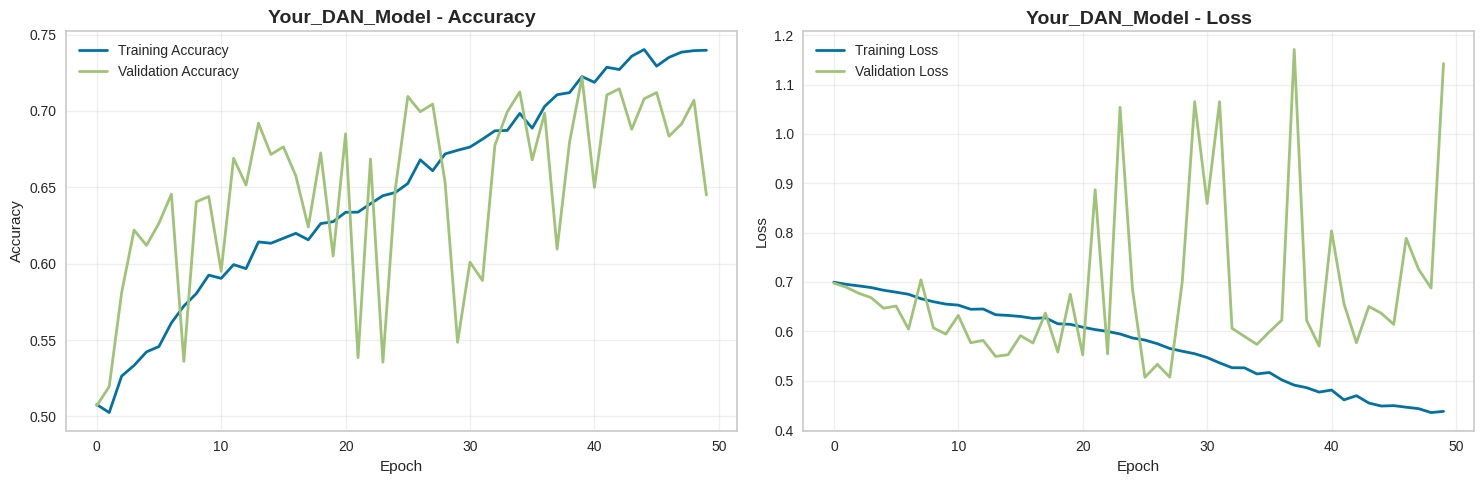

Saving detailed learning curves...


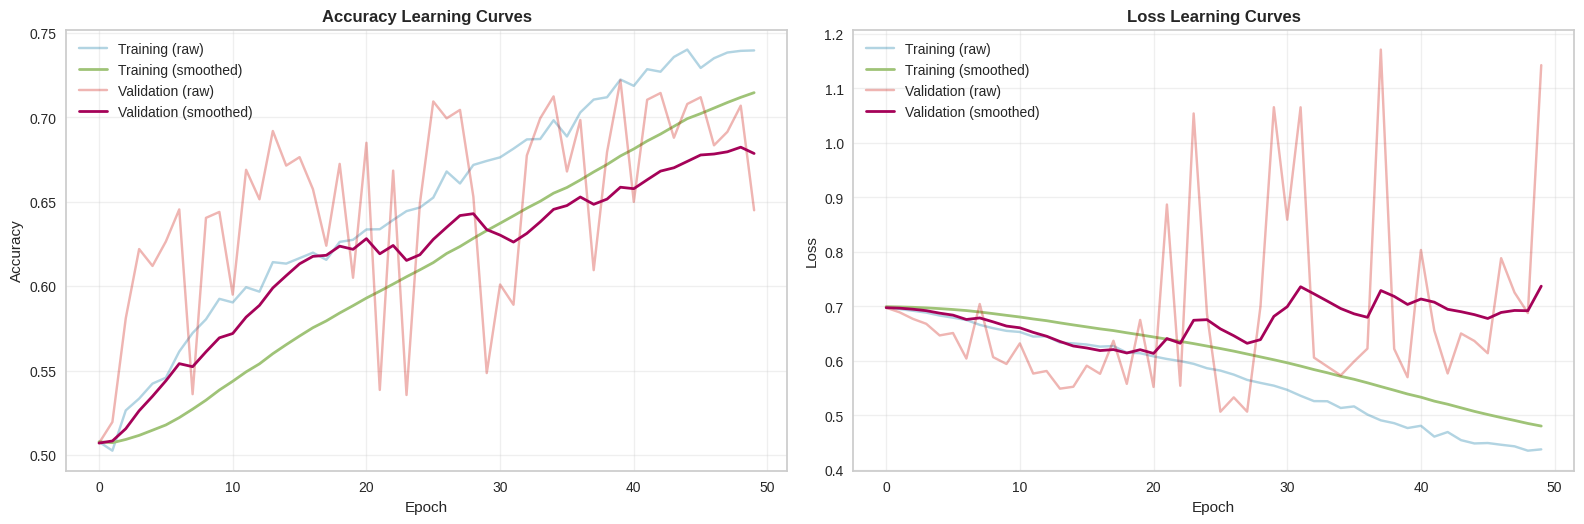

Training plots saved to: /kaggle/working/training_plots

Available metrics in history: ['accuracy', 'loss', 'val_accuracy', 'val_loss']

GENERATING TRAINING REPORT
Training report saved to: /kaggle/working/training_reports/Your_DAN_Model_training_report.txt


In [12]:
if 'history' in globals():
    print("VISUALIZING TRAINING RESULTS")
    print("=" * 50)
    
    print("Generating quick visualization...")
    quick_visualize_training(history, "Your_DAN_Model")
    
    print("\n" + "=" * 50)
    print("GENERATING DETAILED PLOTS")
    print("=" * 50)
    
    try:
        # 1. Print summary statistics
        print_training_summary(history)
        
        # 2. Check if it's a dual-output model
        is_dual_output = any('classifier' in key for key in history.history.keys())
        
        if is_dual_output:
            # Dual output model visualization
            print("Dual-output model detected - plotting classifier and generator metrics...")
            plot_dual_output_training(history, "Your_DAN_Model")
        else:
            # Single output model visualization
            print("Single-output model detected - plotting basic training curves...")
            plot_training_history(history, "Your_DAN_Model")
        
        # 3. Plot detailed learning curves
        print("\nPlotting detailed learning curves...")
        plot_learning_curves_detailed(history)
        
        # 4. Save all plots
        print("\nSaving plots to files...")
        save_training_plots(history, "Your_DAN_Model")
        
    except Exception as e:
        print(f"Error in detailed plotting: {e}")
        print("Using quick visualization only.")
    
    # 5. Show available metrics
    print(f"\nAvailable metrics in history: {list(history.history.keys())}")
    
else:
    print("No training history found. Please train the model first.")
    print("Make sure the 'history' variable exists from model.fit()")


def create_training_report(history, model_name="Your_DAN_Model"):
 
    report_dir = "/kaggle/working/training_reports"
    os.makedirs(report_dir, exist_ok=True)
    
    report_path = f"{report_dir}/{model_name}_training_report.txt"
    
    with open(report_path, 'w') as f:
        f.write(f"TRAINING REPORT - {model_name}\n")
        f.write("=" * 50 + "\n\n")
        
        f.write("MODEL METRICS SUMMARY:\n")
        f.write("-" * 30 + "\n")
        
        for metric in history.history.keys():
            values = history.history[metric]
            if 'accuracy' in metric or 'mae' in metric:
                best_epoch = np.argmax(values) + 1
                best_value = max(values)
                f.write(f"{metric}: {best_value:.4f} (epoch {best_epoch})\n")
            else:
                best_epoch = np.argmin(values) + 1
                best_value = min(values)
                f.write(f"{metric}: {best_value:.4f} (epoch {best_epoch})\n")
        
        f.write(f"\nTotal training epochs: {len(history.history['loss'])}\n")
        
        # Final values
        f.write("\nFINAL EPOCH VALUES:\n")
        f.write("-" * 30 + "\n")
        for metric in history.history.keys():
            final_value = history.history[metric][-1]
            f.write(f"{metric}: {final_value:.4f}\n")
    
    print(f"Training report saved to: {report_path}")


if 'history' in globals():
    print("\n" + "=" * 50)
    print("GENERATING TRAINING REPORT")
    print("=" * 50)
    create_training_report(history, "Your_DAN_Model")

# Testing and Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import json

def test_model_predictions(model, X_test, y_test, num_samples=10):

    print("TESTING MODEL PREDICTIONS")
    print("=" * 60)
    
    print("Generating predictions for test set...")
    predictions = model.predict(X_test, verbose=1)
    
    if isinstance(predictions, list):
        y_pred = predictions[0]  # Classifier output
        print("Dual-output model detected - using classifier predictions")
    else:
        # Single output model
        y_pred = predictions
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
    print(f"Overall Test Accuracy: {overall_accuracy:.4f}")
    
    print(f"\nTesting {num_samples} individual samples:")
    print("-" * 50)
    
    correct_predictions = 0
    total_predictions = num_samples
    
    for i in range(min(num_samples, len(X_test))):
        sample = X_test[i:i+1]
        true_label = y_true_classes[i]
        
        sample_pred = model.predict(sample, verbose=0)
        if isinstance(sample_pred, list):
            sample_pred = sample_pred[0]  # Classifier output
        
        pred_class = np.argmax(sample_pred[0])
        confidence = np.max(sample_pred[0])
        
        is_correct = (pred_class == true_label)
        if is_correct:
            correct_predictions += 1
        
        true_type = "COVER" if true_label == 0 else "STEGO"
        pred_type = "COVER" if pred_class == 0 else "STEGO"
        status = "CORRECT" if is_correct else "WRONG"
        
        print(f"Sample {i+1}: True={true_type}, Pred={pred_type}, "
              f"Confidence={confidence:.4f} - {status}")
    
    print(f"\nIndividual Sample Accuracy: {correct_predictions}/{total_predictions} "
          f"({correct_predictions/total_predictions:.2%})")
    
    return y_pred, y_pred_classes, y_true_classes

def visualize_predictions(model, X_test, y_test, num_images=8):

    print("\nVISUALIZING PREDICTIONS")
    print("=" * 60)
    
    indices = np.random.choice(len(X_test), min(num_images, len(X_test)), replace=False)
    
    cols = 4
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (ax, sample_idx) in enumerate(zip(axes.flat, indices)):
        sample = X_test[sample_idx:sample_idx+1]
        true_label = np.argmax(y_test[sample_idx])
        
        pred = model.predict(sample, verbose=0)
        if isinstance(pred, list):
            pred = pred[0]  # Classifier output
        
        pred_class = np.argmax(pred[0])
        confidence = np.max(pred[0])
        
        true_type = "COVER" if true_label == 0 else "STEGO"
        pred_type = "COVER" if pred_class == 0 else "STEGO"
        is_correct = (pred_class == true_label)
        
        ax.imshow(sample[0, :, :, 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
        color = 'green' if is_correct else 'red'
        title = f"True: {true_type}\nPred: {pred_type}\nConf: {confidence:.3f}"
        ax.set_title(title, color=color, fontsize=10)
        
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2)
    
    for idx in range(len(indices), rows * cols):
        axes.flat[idx].set_visible(False)
    
    plt.suptitle('Model Predictions on Test Images\n(Green=Correct, Red=Wrong)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=['COVER', 'STEGO']):

    print("\nCONFUSION MATRIX ANALYSIS")
    print("=" * 60)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Number of Samples'})
    
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    print("-" * 50)
    print(classification_report(y_true, y_pred, target_names=classes))
    
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nDetailed Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (Stego detection reliability)")
    print(f"Recall:    {recall:.4f} (Stego detection completeness)")
    print(f"F1-Score:  {f1:.4f}")
    print(f"False Positive Rate: {fp/(fp+tn):.4f} (Cover misclassified as Stego)")
    print(f"False Negative Rate: {fn/(fn+tp):.4f} (Stego misclassified as Cover)")

def analyze_prediction_confidence(model, X_test, y_test):

    print("\nPREDICTION CONFIDENCE ANALYSIS")
    print("=" * 60)
    
    predictions = model.predict(X_test, verbose=0)
    if isinstance(predictions, list):
        predictions = predictions[0]  # Classifier output
    
    y_true_classes = np.argmax(y_test, axis=1)
    confidences = np.max(predictions, axis=1)
    predicted_classes = np.argmax(predictions, axis=1)
    

    correct_mask = (predicted_classes == y_true_classes)
    incorrect_mask = ~correct_mask
    
    correct_confidences = confidences[correct_mask]
    incorrect_confidences = confidences[incorrect_mask]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Confidence distribution
    ax1.hist(correct_confidences, bins=20, alpha=0.7, label='Correct Predictions', color='green')
    ax1.hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect Predictions', color='red')
    ax1.set_xlabel('Prediction Confidence')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Prediction Confidence Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Confidence vs accuracy
    confidence_bins = np.linspace(0.5, 1.0, 11)
    accuracy_per_bin = []
    
    for i in range(len(confidence_bins)-1):
        low = confidence_bins[i]
        high = confidence_bins[i+1]
        mask = (confidences >= low) & (confidences < high)
        if np.sum(mask) > 0:
            bin_accuracy = np.mean(predicted_classes[mask] == y_true_classes[mask])
            accuracy_per_bin.append(bin_accuracy)
        else:
            accuracy_per_bin.append(0)
    
    ax2.bar(confidence_bins[:-1], accuracy_per_bin, width=0.05, alpha=0.7, color='blue')
    ax2.set_xlabel('Confidence Bin')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs Prediction Confidence')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average confidence - Correct predictions: {np.mean(correct_confidences):.4f}")
    print(f"Average confidence - Incorrect predictions: {np.mean(incorrect_confidences):.4f}")
    print(f"Overall average confidence: {np.mean(confidences):.4f}")

def test_specific_samples(model, X_test, y_test, sample_indices=None):

    print("\nTESTING SPECIFIC SAMPLES")
    print("=" * 60)
    
    if sample_indices is None:
        predictions = model.predict(X_test, verbose=0)
        if isinstance(predictions, list):
            predictions = predictions[0]
        
        confidences = np.max(predictions, axis=1)
        y_pred_classes = np.argmax(predictions, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
        
        # Find low confidence predictions
        low_conf_indices = np.where(confidences < 0.7)[0][:3]
        
        # Find wrong predictions
        wrong_indices = np.where(y_pred_classes != y_true_classes)[0][:3]
        
        # Find high confidence correct predictions
        correct_mask = (y_pred_classes == y_true_classes)
        high_conf_correct = np.where((confidences > 0.9) & correct_mask)[0][:2]
        
        sample_indices = np.concatenate([low_conf_indices, wrong_indices, high_conf_correct])
    
    print(f"Testing {len(sample_indices)} specific samples:")
    print("-" * 50)
    
    for i, idx in enumerate(sample_indices):
        sample = X_test[idx:idx+1]
        true_label = np.argmax(y_test[idx])
        
        pred = model.predict(sample, verbose=0)
        if isinstance(pred, list):
            pred = pred[0]
        
        pred_class = np.argmax(pred[0])
        confidence = np.max(pred[0])
        is_correct = (pred_class == true_label)
        
        true_type = "COVER" if true_label == 0 else "STEGO"
        pred_type = "COVER" if pred_class == 0 else "STEGO"
        
        print(f"Sample {idx}: True={true_type}, Pred={pred_type}, "
              f"Confidence={confidence:.4f}, Correct={is_correct}")

def save_test_results(model, X_test, y_test, save_path="/kaggle/working/test_results"):

    import os
    import json
    
    os.makedirs(save_path, exist_ok=True)
    
    predictions = model.predict(X_test, verbose=0)
    if isinstance(predictions, list):
        predictions = predictions[0]
    
    y_pred_classes = np.argmax(predictions, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    from sklearn.metrics import classification_report, confusion_matrix
    
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    report = classification_report(y_true_classes, y_pred_classes, 
                                 target_names=['COVER', 'STEGO'], output_dict=True)
    
    def convert_numpy_types(obj):
        if isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        else:
            return obj
    
    results = {
        'test_accuracy': float(np.mean(y_pred_classes == y_true_classes)),
        'confusion_matrix': cm.tolist(),
        'classification_report': convert_numpy_types(report),
        'total_samples': int(len(X_test)),
        'cover_samples': int(np.sum(y_true_classes == 0)),
        'stego_samples': int(np.sum(y_true_classes == 1)),
        'predictions_sample': {
            'first_10_true': y_true_classes[:10].tolist(),
            'first_10_pred': y_pred_classes[:10].tolist(),
            'first_10_confidences': np.max(predictions[:10], axis=1).tolist()
        }
    }
    
    with open(f"{save_path}/test_results.json", 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Test results saved to: {save_path}/test_results.json")
    
    with open(f"{save_path}/test_summary.txt", 'w') as f:
        f.write("MODEL TEST RESULTS SUMMARY\n")
        f.write("=" * 40 + "\n\n")
        f.write(f"Test Accuracy: {results['test_accuracy']:.4f}\n")
        f.write(f"Total Samples: {results['total_samples']}\n")
        f.write(f"Cover Samples: {results['cover_samples']}\n")
        f.write(f"Stego Samples: {results['stego_samples']}\n\n")
        
        f.write("Confusion Matrix:\n")
        f.write(f"[[{cm[0,0]}, {cm[0,1]}],\n")
        f.write(f" [{cm[1,0]}, {cm[1,1]}]]\n\n")
        
        f.write("Classification Report:\n")
        f.write(classification_report(y_true_classes, y_pred_classes, target_names=['COVER', 'STEGO']))
    
    print(f"Test summary saved to: {save_path}/test_summary.txt")


def simple_test_model(model, X_test, y_test):
    """
    Simple step-by-step testing without complex visualizations
    """
    print("SIMPLE MODEL TESTING")
    print("=" * 50)
    
    # Basic prediction
    predictions = model.predict(X_test, verbose=1)
    if isinstance(predictions, list):
        predictions = predictions[0]
        print("Dual-output model: using classifier predictions")
    
    y_pred_classes = np.argmax(predictions, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Basic metrics
    accuracy = np.mean(y_pred_classes == y_true_classes)
    print(f"\nBasic Test Accuracy: {accuracy:.4f}")
    
    # Quick confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print(f"\nConfusion Matrix:")
    print(f"True\\Pred | COVER | STEGO")
    print(f"COVER     | {cm[0,0]:5d} | {cm[0,1]:5d}")
    print(f"STEGO     | {cm[1,0]:5d} | {cm[1,1]:5d}")
    
    return predictions, y_pred_classes, y_true_classes

MODEL TESTING AND PREDICTION ANALYSIS
1. Running simple test...
SIMPLE MODEL TESTING
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Basic Test Accuracy: 0.6656

Confusion Matrix:
True\Pred | COVER | STEGO
COVER     |  4532 |   468
STEGO     |  2876 |  2124

2. Running full analysis...
TESTING MODEL PREDICTIONS
Generating predictions for test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Overall Test Accuracy: 0.6656

Testing 15 individual samples:
--------------------------------------------------
Sample 1: True=COVER, Pred=COVER, Confidence=0.7343 - CORRECT
Sample 2: True=COVER, Pred=COVER, Confidence=0.9960 - CORRECT
Sample 3: True=COVER, Pred=STEGO, Confidence=0.5872 - WRONG
Sample 4: True=COVER, Pred=COVER, Confidence=0.9987 - CORRECT
Sample 5: True=COVER, Pred=COVER, Confidence=0.8388 - CORRECT
Sample 6: True=COVER, Pred=COVER, Confidence=0.9971 - CORRECT
Sample 7: True=COVER, Pred=COVER, Confidence=1.0000 - CORRECT
Sample 8: True=COVER, Pred=COVER, Confidence=0.9999 - CORRECT
Samp

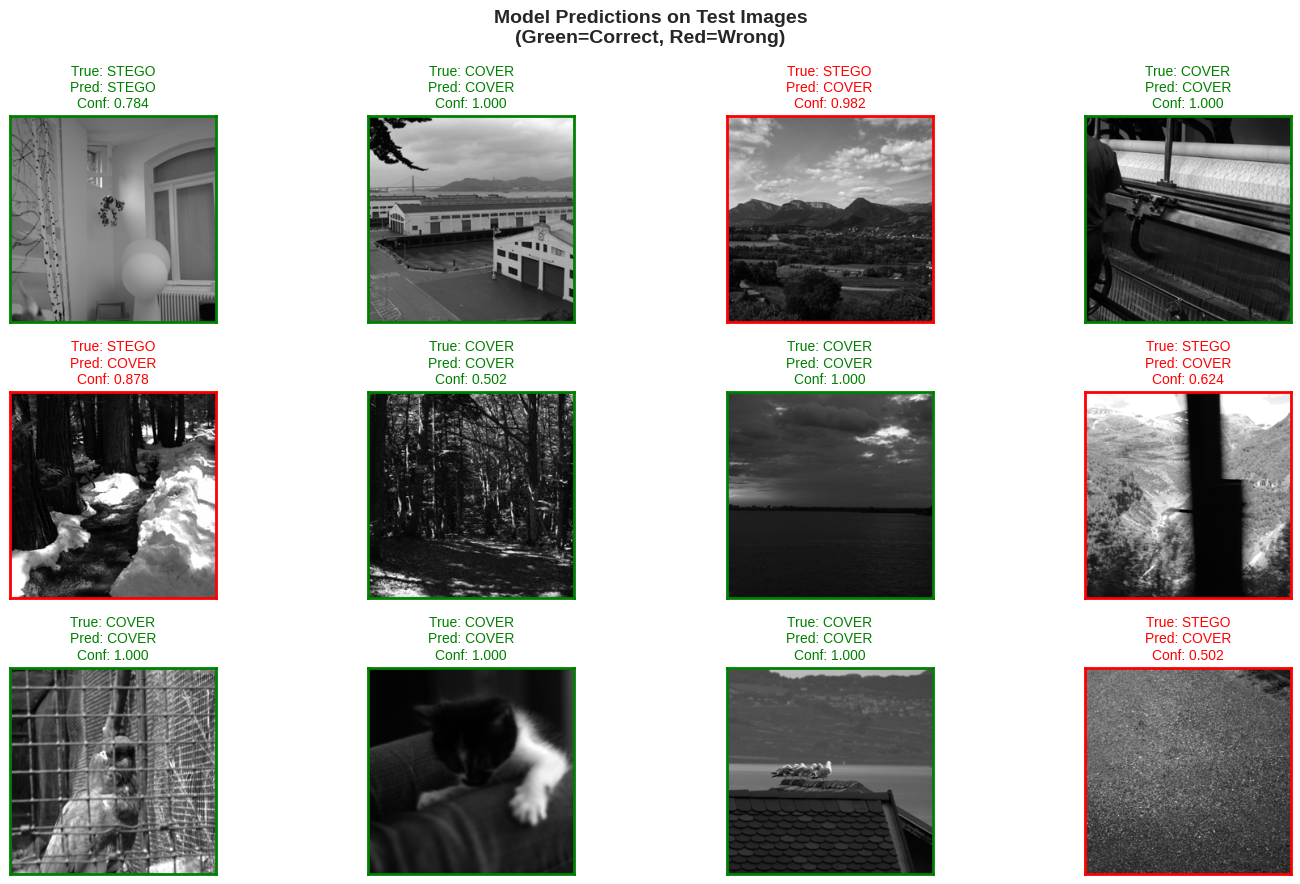


CONFUSION MATRIX ANALYSIS


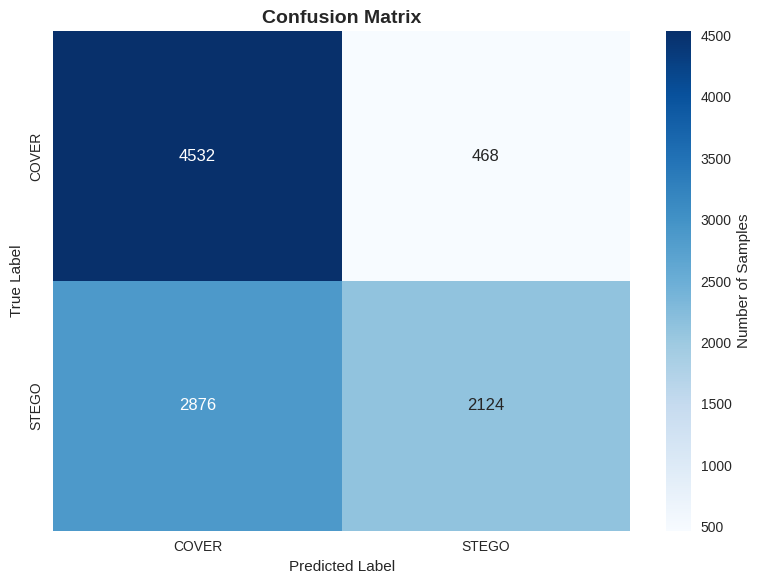


Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

       COVER       0.61      0.91      0.73      5000
       STEGO       0.82      0.42      0.56      5000

    accuracy                           0.67     10000
   macro avg       0.72      0.67      0.65     10000
weighted avg       0.72      0.67      0.65     10000


Detailed Metrics:
Accuracy:  0.6656
Precision: 0.8194 (Stego detection reliability)
Recall:    0.4248 (Stego detection completeness)
F1-Score:  0.5595
False Positive Rate: 0.0936 (Cover misclassified as Stego)
False Negative Rate: 0.5752 (Stego misclassified as Cover)

PREDICTION CONFIDENCE ANALYSIS


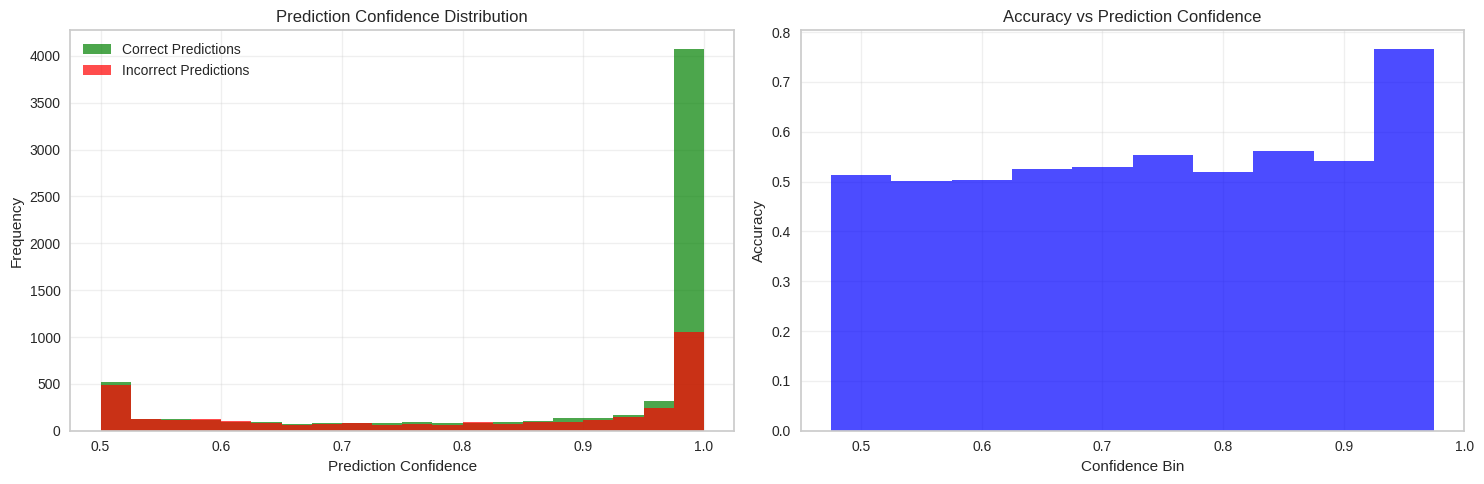

Average confidence - Correct predictions: 0.8911
Average confidence - Incorrect predictions: 0.7990
Overall average confidence: 0.8603

TESTING SPECIFIC SAMPLES
Testing 8 specific samples:
--------------------------------------------------
Sample 2: True=COVER, Pred=STEGO, Confidence=0.5872, Correct=False
Sample 13: True=COVER, Pred=COVER, Confidence=0.5574, Correct=True
Sample 37: True=COVER, Pred=COVER, Confidence=0.6578, Correct=True
Sample 2: True=COVER, Pred=STEGO, Confidence=0.5872, Correct=False
Sample 21: True=COVER, Pred=STEGO, Confidence=0.9824, Correct=False
Sample 55: True=COVER, Pred=STEGO, Confidence=0.6275, Correct=False
Sample 1: True=COVER, Pred=COVER, Confidence=0.9960, Correct=True
Sample 3: True=COVER, Pred=COVER, Confidence=0.9987, Correct=True

7. Saving test results...
Test results saved to: /kaggle/working/test_results/test_results.json
Test summary saved to: /kaggle/working/test_results/test_summary.txt

FINAL TEST ACCURACY: 0.6656 (66.56%)


In [14]:
print("MODEL TESTING AND PREDICTION ANALYSIS")
print("=" * 70)

try:
    # Option 1: Simple testing 
    print("1. Running simple test...")
    predictions, y_pred_classes, y_true_classes = simple_test_model(model, X_test, y_test)
    
    # Option 2: Full testing 
    print("\n2. Running full analysis...")
    y_pred, y_pred_classes, y_true_classes = test_model_predictions(
        model, X_test, y_test, num_samples=15
    )
    
    # 3. Visualize predictions
    visualize_predictions(model, X_test, y_test, num_images=12)
    
    # 4. Confusion matrix and detailed metrics
    plot_confusion_matrix(y_true_classes, y_pred_classes)
    
    # 5. Confidence analysis
    analyze_prediction_confidence(model, X_test, y_test)
    
    # 6. Test specific samples
    test_specific_samples(model, X_test, y_test)
    
    # 7. Save results
    print("\n7. Saving test results...")
    save_test_results(model, X_test, y_test)
    
    # Final summary
    final_accuracy = np.mean(y_pred_classes == y_true_classes)
    print("\n" + "=" * 70)
    print(f"FINAL TEST ACCURACY: {final_accuracy:.4f} ({final_accuracy:.2%})")
    print("=" * 70)

except Exception as e:
    print(f"Error during testing: {e}")
    print("Trying simplified testing only...")
    
    # Fallback to simple testing
    predictions, y_pred_classes, y_true_classes = simple_test_model(model, X_test, y_test)
    save_test_results(model, X_test, y_test)